In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Make matplotlib plots bigger
plt.rcParams['figure.figsize'] = [15, 9]

We want to figure out the scale, rotation and translation between two images using phase correlation. We will transform an image with known parameters, and try to align it to the original. Because rotating and translating the image exposes the borders of the image, both images are cropped.

The Cat Lenna image is courtesy of [Captain Disillusion](https://www.youtube.com/@CaptainDisillusion).

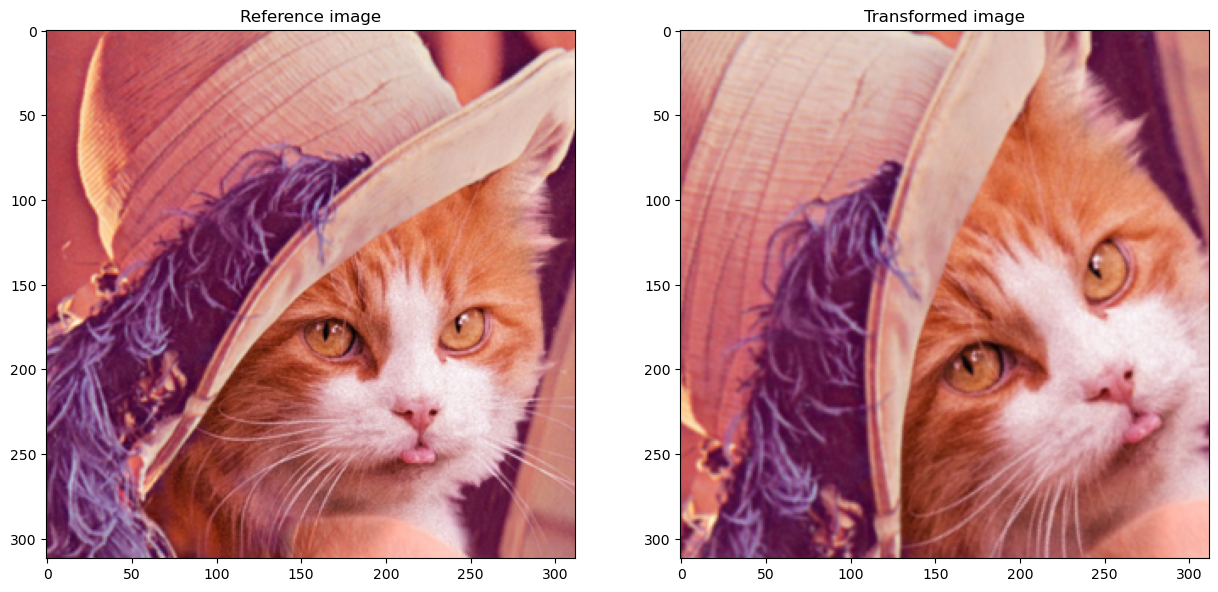

In [2]:
ref_image = plt.imread('images/Cat-Lenna.jpg')

translate_y, translate_x = 25.4, -10.2
scale = 1.2
rotation_degrees = 33.5

# Create rotation matrix around center with scaling
transform_matrix = cv2.getRotationMatrix2D(
    center=(ref_image.shape[1] // 2, ref_image.shape[0] // 2),
    angle=rotation_degrees,
    scale=scale)

# Add translation to the matrix
transform_matrix[0, 2] += translate_x
transform_matrix[1, 2] += translate_y

transformed_image = cv2.warpAffine(
    ref_image,
    transform_matrix,
    dsize=(ref_image.shape[1], ref_image.shape[0]))

# Crop the images to remove borders that may appear due to transformation
crop_margin = 100

ref_image = ref_image[
    crop_margin:-crop_margin,
    crop_margin:-crop_margin]

transformed_image = transformed_image[
    crop_margin:-crop_margin,
    crop_margin:-crop_margin]

fig, ax = plt.subplots(1, 2)
_ = ax[0].imshow(ref_image)
_ = ax[0].set_title('Reference image')
_ = ax[1].imshow(transformed_image)
_ = ax[1].set_title('Transformed image')

In [3]:
# We don't need colors, so we convert to grayscale
ref_image_gray = cv2.cvtColor(ref_image, cv2.COLOR_RGB2GRAY)
transformed_image_gray = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2GRAY)

We start by figuring out the rotation and scale. We can find the rotation and scale by putting both images through a Fast Fourier Transform, and then finding a translation between the results using phase correlation. One axis corresponds to rotation, and another to scale. We apply a bandpass filter to the image before converting to the frequency domain to suppress frequencies that could mess with the correlation.

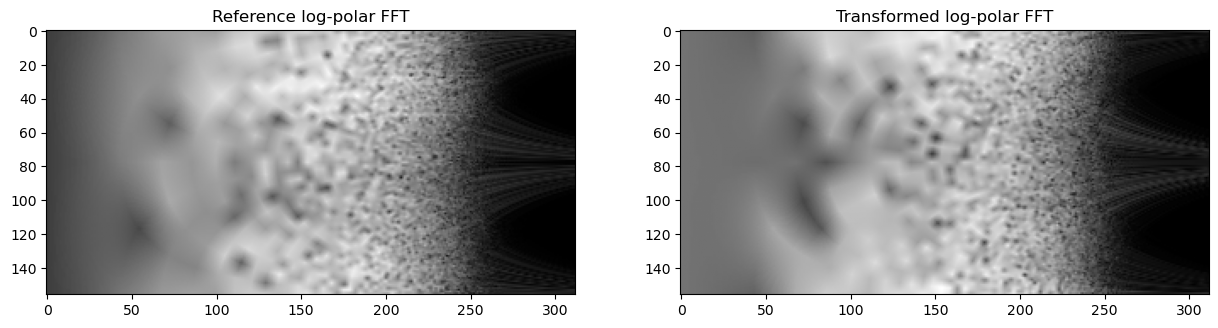

In [4]:
import skimage.filters

# Shape of all following images
shape = ref_image_gray.shape

filtered_ref_image = skimage.filters.difference_of_gaussians(ref_image_gray, low_sigma=2, high_sigma=4)
filtered_transformed_image = skimage.filters.difference_of_gaussians(transformed_image_gray, low_sigma=2, high_sigma=4)

shortest_side = np.min(shape)
radius = shortest_side // 2
def log_polar_fft(image, radius):
    fft = np.abs(np.fft.fftshift(np.fft.fft2(image)))
    # Amplitude spectra have very high values in the low frequencies, so we use logarithm to compress the range
    fft_mag_log = np.log(1.0 + fft)
    log_polar = cv2.warpPolar(
        src=fft_mag_log,
        dsize=(fft_mag_log.shape[1], fft_mag_log.shape[0]),
        center=(fft_mag_log.shape[1] // 2, fft_mag_log.shape[0] // 2),
        maxRadius=radius,
        flags=cv2.INTER_LINEAR | cv2.WARP_POLAR_LOG)
    return log_polar

ref_log_polar = log_polar_fft(filtered_ref_image, radius)
transformed_log_polar = log_polar_fft(filtered_transformed_image, radius)

# We only need half of the log-polar FFTs, as they are symmetric
ref_log_polar = ref_log_polar[:ref_log_polar.shape[0] // 2, :]
transformed_log_polar = transformed_log_polar[:transformed_log_polar.shape[0] // 2, :]

# Display the log-polar FFTs
fig, ax = plt.subplots(1, 2)
_ = ax[0].imshow(ref_log_polar, cmap='gray')
_ = ax[0].set_title('Reference log-polar FFT')
_ = ax[1].imshow(transformed_log_polar, cmap='gray')
_ = ax[1].set_title('Transformed log-polar FFT')

In [5]:
correlation_result = cv2.phaseCorrelate(ref_log_polar, transformed_log_polar)
recovered_rotation = 360.0 * -correlation_result[0][1] / shape[0]

print(f'OpenCV recovered rotation: {recovered_rotation} degrees')
print(f'Expected rotation: {rotation_degrees} degrees')

# Recover scale from the correlation result
klog =  shortest_side / np.log(radius)
recovered_scale = np.exp(-correlation_result[0][0] / klog)
print(f'OpenCV recovered scale: {recovered_scale}')
print(f'Expected scale: {scale}')

OpenCV recovered rotation: 33.656478124079676 degrees
Expected rotation: 33.5 degrees
OpenCV recovered scale: 1.1930561623527522
Expected scale: 1.2


Now we have recovered the rotation and scale, we can apply a counter rotation and scaling, which will then leave only the translation. We can recover the translation vector with regular phase correlation.

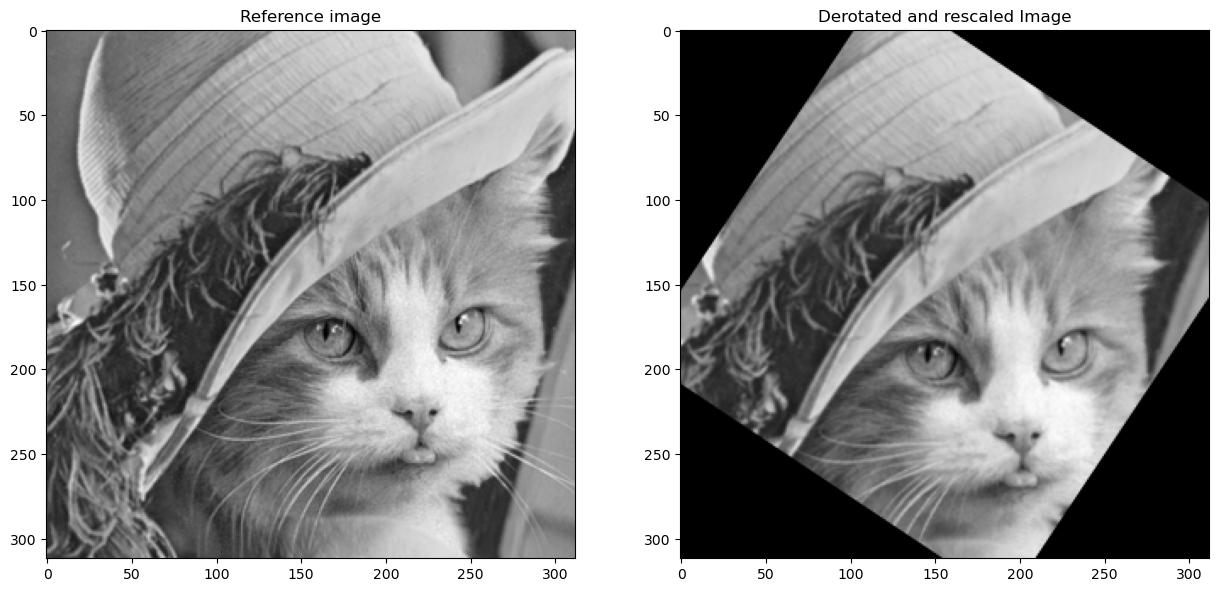

In [6]:
derotate_rescale_matrix = cv2.getRotationMatrix2D((transformed_image.shape[1] // 2, transformed_image.shape[0] // 2), -recovered_rotation, 1.0 / recovered_scale)
transformed_image_recovered = cv2.warpAffine(
    transformed_image_gray,
    derotate_rescale_matrix,
    dsize=(transformed_image_gray.shape[1], transformed_image_gray.shape[0]))

fig, ax = plt.subplots(1, 2)
_ = ax[0].imshow(ref_image_gray, cmap='gray')
_ = ax[0].set_title('Reference image')
_ = ax[1].imshow(transformed_image_recovered, cmap='gray')
_ = ax[1].set_title('Derotated and rescaled Image')

OpenCV recovered translation: [-12.77723065  18.84648779] pixels


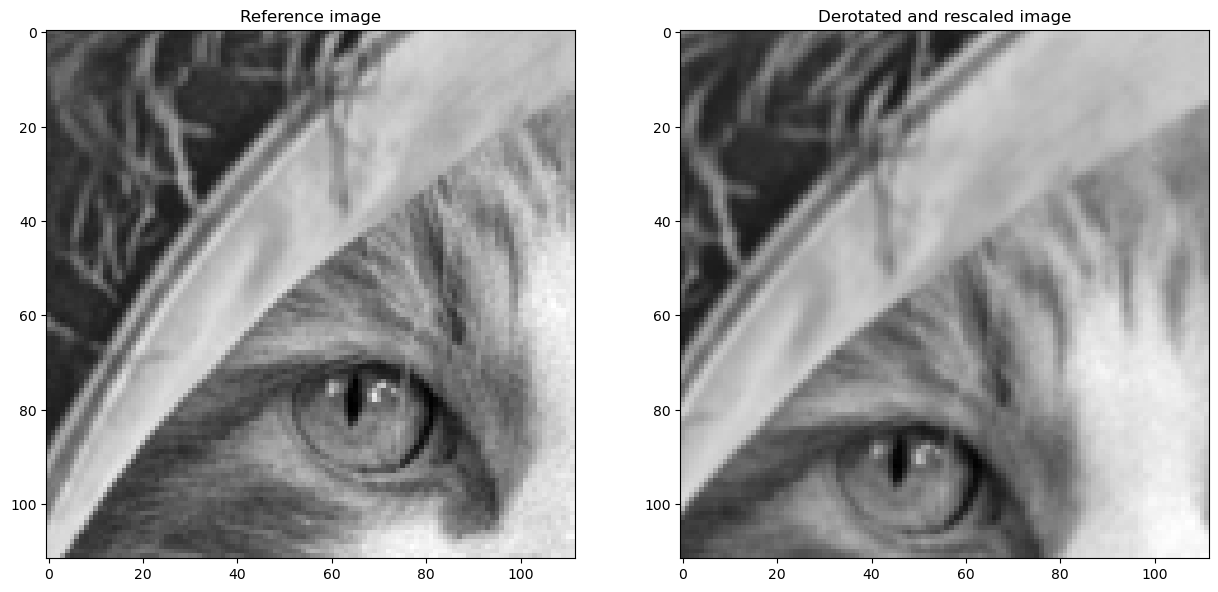

In [7]:
# For this example, we crop the image to remove the borders that may appear due to transformation
cropped_translation_image = transformed_image_recovered[100:-100, 100:-100].astype(np.float32)
cropped_ref_image = ref_image_gray[100:-100, 100:-100].astype(np.float32)
fig, ax = plt.subplots(1,2)
_ = ax[0].imshow(cropped_ref_image, cmap='gray')
_ = ax[0].set_title('Reference image')
_ = ax[1].imshow(cropped_translation_image, cmap='gray')
_ = ax[1].set_title('Derotated and rescaled image')

correlation_result_translation = cv2.phaseCorrelate(cropped_ref_image, cropped_translation_image)
recovered_translation = -np.array(correlation_result_translation[0])[::-1]
print(f'OpenCV recovered translation: {recovered_translation} pixels')
# The translation might be different from the original one due to the center of rotation being different compared to the original

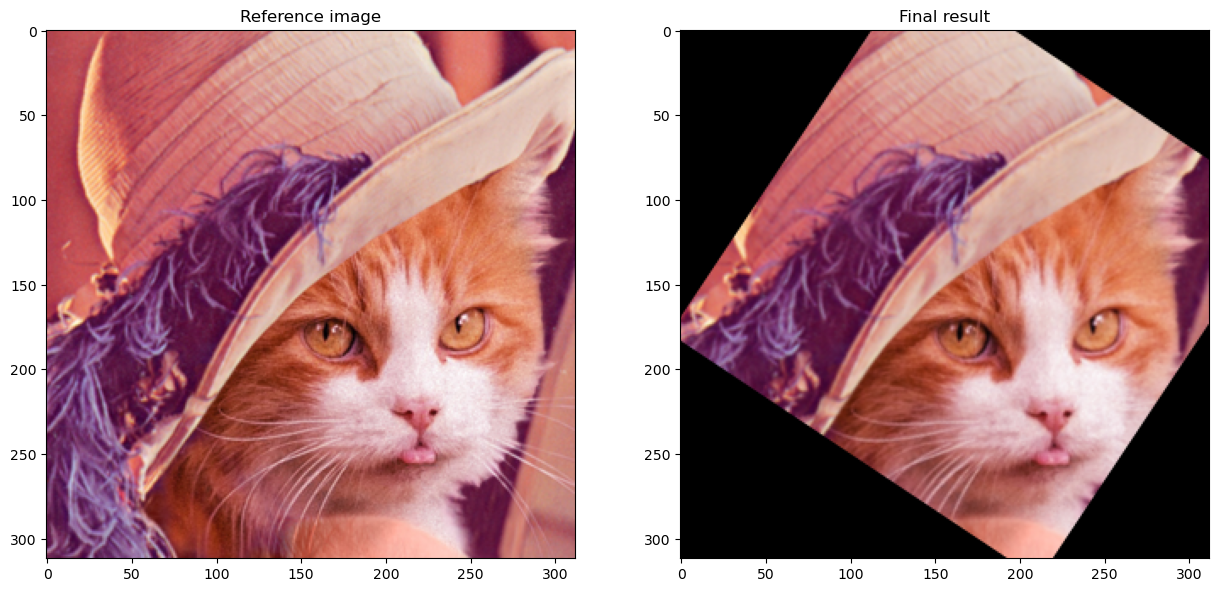

In [8]:
undo_translation_matrix = np.array([[1.0, 0.0, recovered_translation[1]],
                                    [0.0, 1.0, recovered_translation[0]],
                                    [0.0, 0.0, 1.0]])
derotate_rescale_matrix_homogeneous = np.vstack([derotate_rescale_matrix, [0.0, 0.0, 1.0]])
final_matrix = (undo_translation_matrix @ derotate_rescale_matrix_homogeneous)[:2, :]
final_result = cv2.warpAffine(transformed_image, final_matrix, dsize=(ref_image.shape[1], ref_image.shape[0]))
fig, ax = plt.subplots(1, 2)
_ = ax[0].imshow(ref_image)
_ = ax[0].set_title('Reference image')
_ = ax[1].imshow(final_result)
_ = ax[1].set_title('Final result')